In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Vocab:
    def __init__(self, counter, sos, eos, pad, unk, min_freq=None):
        self.sos = sos
        self.eos = eos
        self.pad = pad
        self.unk = unk
        
        self.pad_idx = 0
        self.unk_idx = 1
        self.sos_idx = 2
        self.eos_idx = 3
        
        self._token2idx = {
            self.sos: self.sos_idx,
            self.eos: self.eos_idx,
            self.pad: self.pad_idx,
            self.unk: self.unk_idx,
        }
        self._idx2token = {idx:token for token, idx in self._token2idx.items()}
    
        
        idx = len(self._token2idx)
        min_freq = 0 if min_freq is None else min_freq
        
        for token, count in counter.items():
            if count > min_freq:
                self._token2idx[token] = idx
                self._idx2token[idx]   = token
                idx += 1
        
        self.vocab_size = len(self._token2idx)
        self.tokens     = list(self._token2idx.keys())
    
    def token2idx(self, token):
        return self._token2idx.get(token, self.pad_idx)
    
    def idx2token(self, idx):
        return self._idx2token.get(idx, self.pad)
    
    def sent2idx(self, sent):
        return [self.token2idx(i) for i in sent]
    
    def idx2sent(self, idx):
        return [self.idx2token(i) for i in idx]
    
    def __len__(self):
        return len(self._token2idx)

In [4]:
class TwitterDataset(Dataset):
    def __init__(self, path):
        data = pickle.load(open(path, 'rb'))
        data = pd.DataFrame.from_dict(data)
        
        texts  = data['text'].values
        labels = data['label'].values
        
        train_texts, val_texts, train_labels, val_labels = \
            train_test_split(texts, labels,test_size=0.33, random_state=42)
        
        words_list = []
        for s in train_texts:
            words_list += s
        words_counter = Counter(words_list)
        
        sos = "<sos>"
        eos = "<eos>"
        pad = "<pad>"
        unk = "<unk>"

        self.vocab = Vocab(words_counter,
                           sos, eos, pad, unk)
        
        self.train_texts  = [self.vocab.sent2idx(row) for row in train_texts]
        self.val_texts    = [self.vocab.sent2idx(row) for row in val_texts]
        self.train_labels = train_labels
        self.val_labels  = val_labels
        
    def __len__(self):
        return len(self.train_texts)
    
    def get_batch(self, batch_size, val=False):
        pad_token = 0
        if val:
            texts, labels = self.val_texts,   self.val_labels
        else:
            texts, labels = self.train_texts, self.train_labels
        
        random_idxs  = np.random.randint(0, len(texts), batch_size)
        batch_texts  = [texts[idx] for idx in random_idxs]
        batch_labels = [labels[idx] for idx in random_idxs]
        texts_lens   = list(map(len, batch_texts))

        sorted_texts_lens, sorted_texts, sorted_labels = list(zip(*sorted(zip(texts_lens, batch_texts, batch_labels), key=lambda x: x[0] ,reverse=True)))      
        
        max_lens = sorted_texts_lens[0]
        
        sorted_padded_texts = [sorted_texts[i] + [pad_token] * (max_lens - sorted_texts_lens[i]) for i in range(batch_size)]
        texts      = torch.LongTensor(sorted_padded_texts) 
        labels     = torch.FloatTensor(sorted_labels)
        texts_lens = torch.FloatTensor(sorted_texts_lens)
        return texts, labels, texts_lens

In [5]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, pad_idx):
        super(RNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
    
        self.embedding = nn.Embedding(vocab_size,embed_size,padding_idx = pad_idx)        
        self.rnn = nn.LSTM(embed_size,hidden_size,batch_first=True)
        self.linear  = nn.Linear(hidden_size, output_size)
        
    def forward(self, text, text_lengths):
        # text = [batch size, sent len, ]
        # embedded = [ batch size, sent len, emb dim]
        # hidden = [num layers * num directions, batch size, hid dim]
        
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        return self.linear(hidden.squeeze(0))

In [6]:
def embeddings():
    embed_dict = {}
    with open('fast_text.vec') as f:
        for line in f.readlines():
            word = line.split()[0]
            vector_string    = line.split()[1:]
            embed_dict[word] = np.array(vector_string, dtype=np.float32) 
    
    matrix_len     = len(dataset.vocab._token2idx)
    weights_matrix = np.zeros((matrix_len, 100))
    words_found    = 0
    for i, word in enumerate(dataset.vocab._token2idx):
        try: 
            weights_matrix[i] = embed_dict[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(100, ))
            
    pretrained_embeddings = torch.FloatTensor(weights_matrix)
    with open('pretrained_embeddings.pickle', 'wb') as f:
        pickle.dump(pretrained_embeddings, f)
    return pretrained_embeddings
#embeddings() run embeddings if using different dataset
pretrained_embeddings = pickle.load(open('pretrained_embeddings.pickle', 'rb'))

In [7]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [8]:
def plot(epoch, batch_idx, train_losses, val_losses, train_accs, val_accs):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(221)
    plt.title('epoch %s. | batch: %s | loss: %s' % (epoch, batch_idx, np.mean(train_losses[-100:])))
    plt.plot(train_losses)
    plt.subplot(222)
    plt.title('epoch %s. | loss: %s' % (epoch, np.mean(val_losses[-100:])))
    plt.plot(val_losses)
    plt.subplot(223)
    plt.title('epoch %s. | batch: %s | accuracy: %s' % (epoch, batch_idx, np.mean(train_accs[-100:])))
    plt.plot(train_accs)
    plt.subplot(224)
    plt.title('epoch %s. | accuracy: %s' % (epoch, np.mean(val_accs[-100:])))
    plt.plot(val_accs)
    plt.tight_layout()
    plt.show()

In [9]:
dataset = TwitterDataset('twitter_prep_data_brackets.pickle')

In [10]:
batch_texts, batch_labels, batch_texts_lens = dataset.get_batch(32)
batch_texts.size(), batch_labels.size(), batch_texts_lens.size() 

(torch.Size([32, 19]), torch.Size([32]), torch.Size([32]))

In [11]:
def step(batch_size, val):
    batch_texts, batch_labels, batch_texts_lens = dataset.get_batch(batch_size, val)
    batch_texts      = batch_texts.to(device)
    batch_labels     = batch_labels.to(device)
    batch_texts_lens = batch_texts_lens.to(device)

    logits = model(batch_texts, batch_texts_lens).squeeze(1)
    loss   = criterion(logits, batch_labels.float())
    acc    = binary_accuracy(logits, batch_labels.float())
    
    return loss, acc

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_size = 100
hidden_size    = 128
output_size    = 1

model = RNN(dataset.vocab.vocab_size, embedding_size, hidden_size, output_size, dataset.vocab.pad_idx).to(device)
model.embedding.weight.data.copy_(pretrained_embeddings)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

batch_size = 64
epoch      = 0
num_epochs = 10

train_losses  = []
val_losses    = []
train_accs    = []
val_accs      = []
best_val_loss = float('inf')

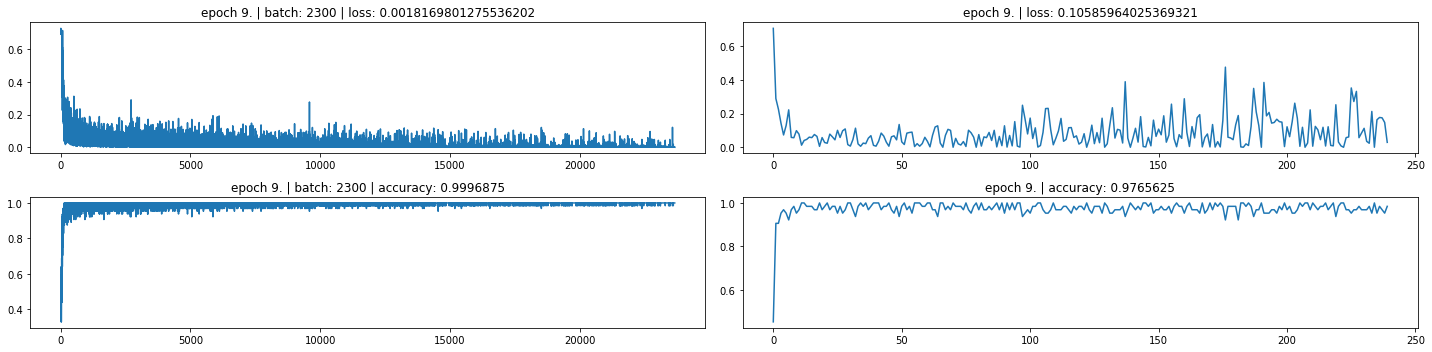

	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 0.029 |  Val. Acc: 98.44%


In [13]:
while epoch < num_epochs:
    for batch_idx in range(len(dataset.train_texts) // batch_size):
        train_loss, train_acc = step(batch_size, val = False)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())
        if batch_idx % 100 == 0:
            with torch.no_grad():
                val_loss, val_acc = step(batch_size, val=True)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), 'checkpoint.pth')
                val_losses.append(val_loss.item())
                val_accs.append(val_acc.item())
            plot(epoch, batch_idx, train_losses, val_losses, train_accs, val_accs)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
            
    epoch += 1 

#### no brackets:
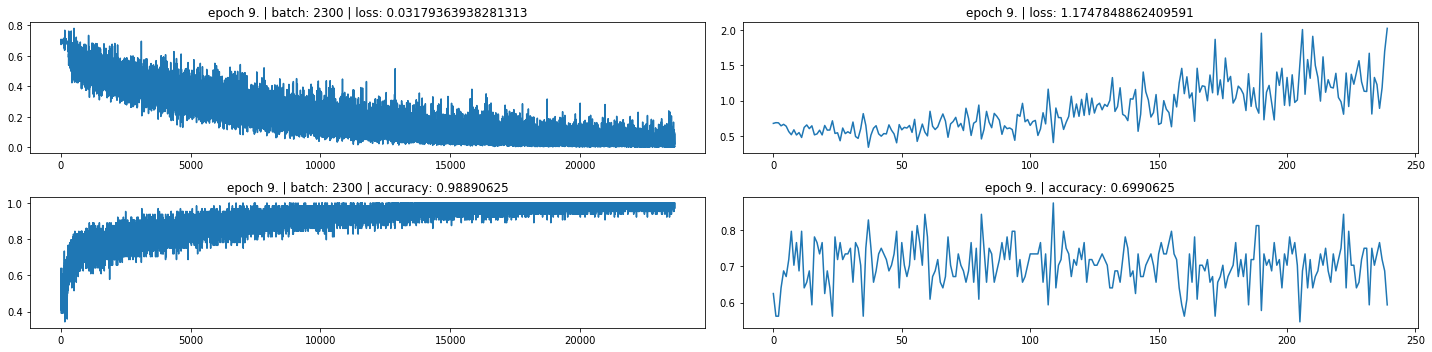

In [13]:
from nltk import (sent_tokenize as splitter, wordpunct_tokenize as tokenizer)

def predict_sentiment(sentence):
    model.load_state_dict(torch.load('checkpoint.pth'))
    model.eval()
    tokenized = [tokenizer(sentence) for sentence in splitter(sentence)]
    indexed   = [dataset.vocab.sent2idx(tokenized[0])]
    length    = [len(indexed[0])]
    tensor    = torch.LongTensor(indexed).to(device)
    pred      = torch.sigmoid(model(tensor, length))
    return pred.item()

In [20]:
sentence = 'все хорошо'
predict_sentiment(sentence)

0.8717909455299377